In [1]:
# import packages
import os
import lap
import copy
import torch
from torch import optim
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

os.chdir("..")
from data.utils import to_one_hot, load_asd_score, load_sfnc
from data.dataset import ConditionalDataset
from models.ivae import iVAE
from models.vae import VAE
from models.ppca import PPCA
from models.utils import EarlyStopper

In [2]:
# define parameters
method = 'vae' # ['ivae', 'vae', 'ppca']
seed = 6
n_layer = 2
hidden_dim = [64, 16]
latent_dim = 2
batch_size = 16
learning_rate = 0.001
n_epoch = 1000
mode = 'save'
cuda = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

res_path = f'/data/users4/xli/interpolation/results/sfnc_asd/{method}/test'
os.mkdir(res_path) if not os.path.exists(res_path) else None

ckpt_file = os.path.join(res_path, f'{method}_layer{n_layer}_dim{hidden_dim}_bs{batch_size}_lr{learning_rate}_seed{seed}.pt')

# load datasets
data_path = '/data/users2/zfu/Matlab/GSU/Neuromark/Results'

# load demographic information
abide1_sub_path = os.path.join(data_path, 'Subject_selection', 'ABIDE1', 'sub_info_ABIDE1_TRall.mat')
abide1_sub_data, abide1_site, invalid_sub_ind = load_asd_score(abide1_sub_path)

# load sFNC
abide1_sfnc_path=os.path.join(data_path, 'SFNC', 'ABIDE1', 'ABIDE_TRall.mat')
abide1_sfnc_data, abide1_sfnc_data_raw = load_sfnc(abide1_sfnc_path, invalid_sub_ind)
abide1_sfnc_data_mean_removed = abide1_sfnc_data_raw - np.mean(abide1_sfnc_data_raw, axis=0)

In [3]:
site_count = {}
for site in list(np.unique(abide1_site)):
    site_count[site] = len(np.where(abide1_site==site)[0])

keys = list(site_count.keys())
values = list(site_count.values())
sorted_value_index = np.argsort(values)
sorted_site_count = {keys[i]: values[i] for i in sorted_value_index}
sorted_site_count

{'LEUVEN_1': 13,
 'CMU': 14,
 'LEUVEN_2': 18,
 'UM_2': 19,
 'UCLA_2': 20,
 'SBL': 20,
 'STANFORD': 24,
 'YALE': 26,
 'OLIN': 27,
 'CALTECH': 32,
 'SDSU': 32,
 'MAX_MUN': 33,
 'KKI': 41,
 'TRINITY': 42,
 'PITT': 43,
 'UM_1': 47,
 'UCLA_1': 70,
 'USM': 82,
 'NYU': 159}

In [4]:
# concatenate patients and controls
n_sub = 266
ind_pt = np.where(((abide1_site=="NYU") | (abide1_site=="USM") | (abide1_site=="UCLA_1")) & (abide1_sub_data[:,0]==1))[0][:n_sub//2]
ind_hc = np.where(((abide1_site=="NYU") | (abide1_site=="USM") | (abide1_site=="UCLA_1")) & (abide1_sub_data[:,0]==2))[0][:n_sub-n_sub//2]
print(f"N patient = {ind_pt.shape[0]}; N control = {ind_hc.shape[0]}")

sfnc_data = np.concatenate((abide1_sfnc_data[ind_pt, :], abide1_sfnc_data[ind_hc, :]), axis=0)
sfnc_data_raw = np.concatenate((abide1_sfnc_data_raw[ind_pt, :], abide1_sfnc_data_raw[ind_hc, :]), axis=0)
sfnc_data_mean_removed = sfnc_data_raw - np.mean(sfnc_data_raw, axis=0)
sub_data = np.concatenate((abide1_sub_data[ind_pt, :], abide1_sub_data[ind_hc, :]), axis=0)

age_pt = abide1_sub_data[ind_pt, -2]
age_hc = abide1_sub_data[ind_hc, -2]
sex_pt = abide1_sub_data[ind_pt, -1]
sex_hc = abide1_sub_data[ind_hc, -1]

n_test = 41
n_pt_test = n_test//2
n_hc_test = n_test - n_pt_test
ind_pt_test = []
ind_hc_test = []
site_patient = abide1_site[ind_pt]
site_control = abide1_site[ind_hc]
site_patient_list = list(np.unique(abide1_site[ind_pt]))
site_control_list = list(np.unique(abide1_site[ind_hc]))

# print("Patient")
for i, s in enumerate(site_patient_list):
  ind = np.where(site_patient == s)[0]
  # stratify test set by site
  n_start = ind[0]
  n_end = int(np.round(len(ind)/len(ind_pt)*n_test*0.5))
  ind_pt_site_test = ind_pt[n_start:n_start+n_end]
  ind_pt_test += list(ind_pt_site_test)
  # print(f"{s} & {len(ind)} & {np.sum(sex_pt[ind]==1)} & {np.sum(sex_pt[ind]==2)} & ${round(np.mean(age_pt[ind]), 2)}\\pm{round(np.std(age_pt[ind]),2)}$ & ${round(np.min(age_pt[ind]),2)}-{round(np.max(age_pt[ind]),2)}$")

# print("Control")
for i, s in enumerate(site_control_list):
  ind = np.where(site_control == s)[0]
  # stratify test set by site
  n_start = ind[0]
  n_end = int(np.round(len(ind)/len(ind_hc)*n_test*0.5))
  if s=="NYU":
    n_end += 1
  ind_hc_site_test = ind_hc[n_start:n_start+n_end]
  ind_hc_test += list(ind_hc_site_test)
  # print(f"{s} & {len(ind)} & {np.sum(sex_hc[ind]==1)} & {np.sum(sex_hc[ind]==2)} & ${round(np.mean(age_hc[ind]), 2)}\\pm{round(np.std(age_hc[ind]),2)}$ & ${round(np.min(age_hc[ind]),2)}-{round(np.max(age_hc[ind]),2)}$")

# split data into training and test sets
n_train = n_sub - n_test
ind_pt_train = list(set(ind_pt) - set(ind_pt_test))
ind_hc_train = list(set(ind_hc) - set(ind_hc_test))

print(f"patient N male = {np.sum(sex_pt==1)}, N female = {np.sum(sex_pt==2)}; N train = {len(ind_pt_train)}, N test = {len(ind_pt_test)}; age mean = {np.mean(age_pt):.2f}, std = {np.std(age_pt):.2f}, min = {np.min(age_pt)}, max = {np.max(age_pt)}")
print(f"control N male = {np.sum(sex_hc==1)}, N female = {np.sum(sex_hc==2)}; N train = {len(ind_hc_train)}, N test = {len(ind_hc_test)}; age mean = {np.mean(age_hc):.2f}, std = {np.std(age_hc):.2f}, min = {np.min(age_hc)}, max = {np.max(age_hc)}")

N patient = 133; N control = 133
patient N male = 119, N female = 14; N train = 113, N test = 20; age mean = 17.01, std = 7.20, min = 7.15, max = 39.1
control N male = 104, N female = 29; N train = 112, N test = 21; age mean = 16.05, std = 5.67, min = 7.29, max = 31.78


In [5]:
# split data into training and test sets
sfnc_data_test = np.concatenate((abide1_sfnc_data[ind_pt_test, :], abide1_sfnc_data[ind_hc_test, :]), axis=0)
sfnc_data_raw_test = np.concatenate((abide1_sfnc_data_raw[ind_pt_test, :], abide1_sfnc_data_raw[ind_hc_test, :]), axis=0)
sfnc_data_mean_removed_test = sfnc_data_raw_test - np.mean(sfnc_data_raw_test, axis=0)
sub_data_test = np.concatenate((abide1_sub_data[ind_pt_test, :], abide1_sub_data[ind_hc_test, :]), axis=0)
y_test = to_one_hot(sub_data_test[:,0])[0][:,1:]

sfnc_data_train = np.concatenate((abide1_sfnc_data[ind_pt_train, :], abide1_sfnc_data[ind_hc_train, :]), axis=0)
sfnc_data_raw_train = np.concatenate((abide1_sfnc_data_raw[ind_pt_train, :], abide1_sfnc_data_raw[ind_hc_train, :]), axis=0)
sfnc_data_mean_removed_train = sfnc_data_raw_train - np.mean(sfnc_data_raw_train, axis=0)
sub_data_train = np.concatenate((abide1_sub_data[ind_pt_train, :], abide1_sub_data[ind_hc_train, :]), axis=0)
y_train = to_one_hot(sub_data_train[:,0])[0][:,1:]

data_dim = sfnc_data_train.shape[1]
aux_dim = y_train.shape[1]

# create data loaders
loader_params = {'num_workers': 1, 'pin_memory': True} if cuda else {}

ds_train = ConditionalDataset(sfnc_data_train.astype(np.float32), y_train.astype(np.float32), device)
data_loader_train = DataLoader(ds_train, shuffle=False, batch_size=batch_size, **loader_params)

ds_test = ConditionalDataset(sfnc_data_test.astype(np.float32), y_test.astype(np.float32), device)
data_loader_test = DataLoader(ds_test, shuffle=False, batch_size=batch_size, **loader_params)

In [6]:
if method == 'vae':
    model = VAE(input_dim=data_dim, 
                latent_dim=latent_dim, 
                hidden_dims=hidden_dim, 
                seed=seed)
    print(model)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
    early_stopper = EarlyStopper(patience=20, threshold=1e-2, min_delta=1e-3)

    # train model
    model.train()

    for it in range(n_epoch):
        loss_train = 0
        for _, (x, _) in enumerate(data_loader_train):
            x = x.view(x.size(0), -1).to(device)
            optimizer.zero_grad()
            x_rec, mean, logvar = model(x)
            loss = model.loss(x_rec, x, mean, logvar)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        loss_train /= len(data_loader_train)
        scheduler.step(loss_train)
        print(f'Epoch: {it}; Loss: {loss_train:.5f}')
        if early_stopper.early_stop(loss_train):
            print(f'Early stopping triggered!')
            break

    # save model checkpoint after training
    torch.save(model.state_dict(), ckpt_file)
    
    x_train, u_train = ds_train.x, ds_train.y
    x_test, u_test = ds_test.x, ds_test.y
    _, z_train, _ = model(x_train)
    _, z_test, _ = model(x_test)
    z_train = z_train.detach().cpu().numpy()
    z_test = z_test.detach().cpu().numpy()

elif method == 'ivae':
    model = iVAE(data_dim=data_dim,
                 latent_dim=latent_dim,
                 aux_dim=aux_dim,
                 hidden_dim=hidden_dim,
                 n_layer=n_layer,
                 activation='xtanh',
                 device=device,
                 seed=seed)
    print(model)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
    early_stopper = EarlyStopper(patience=20, threshold=1e-2, min_delta=1e-3)

    # train model
    model.train()

    for it in range(n_epoch):
        loss_train = 0
        for _, (x, u) in enumerate(data_loader_train):
            optimizer.zero_grad()
            x, u = x.to(device), u.to(device)
            loss, z_est = model.loss(x, u)
            loss.mul(-1).backward()
            optimizer.step()
            loss_train += -loss.item()
        loss_train /= len(data_loader_train)
        scheduler.step(loss_train)
        print(f'Epoch: {it}; Loss: {loss_train:.3f}')
        if early_stopper.early_stop(loss_train):
            print(f'Early stopping triggered!')
            break

    # save model checkpoint after training
    torch.save(model.state_dict(), ckpt_file)

    x_train, u_train = ds_train.x, ds_train.y
    x_test, u_test = ds_test.x, ds_test.y
    _, _, z_train, _ = model(x_train, u_train)
    _, _, z_test, _ = model(x_test, u_test)
    z_train = z_train.detach().cpu().numpy()
    z_test = z_test.detach().cpu().numpy()

elif method == 'ppca':
    model = PPCA(latent_dim=latent_dim, max_iter=1000, seed=seed)
    model.fit(sfnc_data_train)
    z_train = model.transform(sfnc_data_train)
    z_test = model.transform(sfnc_data_test)

np.save(os.path.join(res_path, 'z_train.npy'), z_train)
np.save(os.path.join(res_path, 'z_test.npy'), z_test)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=1378, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.5)
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): LeakyReLU(negative_slope=0.5)
  )
  (fc_mean): Linear(in_features=16, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.5)
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.5)
    (4): Linear(in_features=64, out_features=1378, bias=True)
  )
)
Epoch: 0; Loss: 1683.22196
Epoch: 1; Loss: 1028.82666
Epoch: 2; Loss: 849.87737
Epoch: 3; Loss: 793.05058
Epoch: 4; Loss: 775.19850
Epoch: 5; Loss: 768.40014
Epoch: 6; Loss: 763.13564
Epoch: 7; Loss: 758.61261
Epoch: 8; Loss: 753.07908
Epoch: 9; Loss: 731.68060
Epoch: 10; Loss: 716.87902
Epoch: 11; Loss: 710.29229
Epoch: 12; Loss: 699.39331
Epoch

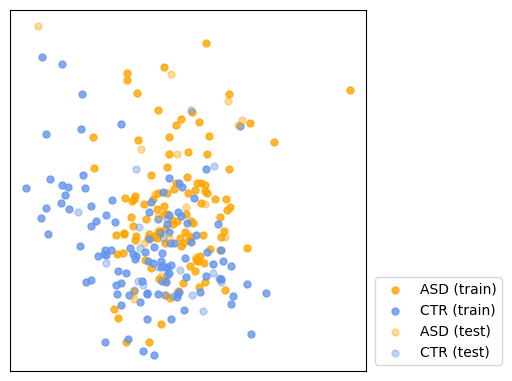

In [7]:
y_train_ind_sz = np.where(y_train[:,0]==1)[0] # patient
y_train_ind_hc = np.where(y_train[:,1]==1)[0] # control

y_test_ind_sz = np.where(y_test[:,0]==1)[0] # patient
y_test_ind_hc = np.where(y_test[:,1]==1)[0] # control

plt.figure(figsize=(5.5,4))
plt.xticks([], [])
plt.yticks([], [])
plt.scatter(z_train[y_train_ind_sz, 0], z_train[y_train_ind_sz, 1], marker='o', alpha=0.8, c='orange', s=25, label='ASD (train)')
plt.scatter(z_train[y_train_ind_hc, 0], z_train[y_train_ind_hc, 1], marker='o', alpha=0.8, c='cornflowerblue', s=25, label='CTR (train)')
plt.scatter(z_test[y_test_ind_sz, 0], z_test[y_test_ind_sz, 1], marker='o', alpha=0.4, c='orange', s=25, label='ASD (test)')
plt.scatter(z_test[y_test_ind_hc, 0], z_test[y_test_ind_hc, 1], marker='o', alpha=0.4, c='cornflowerblue', s=25, label='CTR (test)')
plt.legend(bbox_to_anchor=(1.4, 0.28))
plt.tight_layout()
plt.savefig(os.path.join(res_path, f'{method}_latent_space.png'), dpi=500)

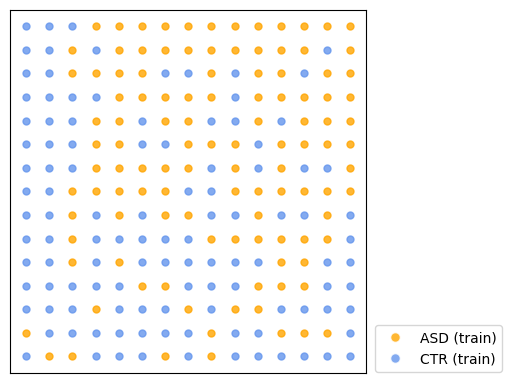

In [8]:
n_train_sq = np.sqrt(n_train).astype(np.int64)
xv, yv = np.meshgrid(np.linspace(0, 1, n_train_sq), np.linspace(0, 1, n_train_sq))
grid = np.dstack((xv, yv)).reshape(-1, 2)
cost = cdist(grid, z_train, 'sqeuclidean')
min_cost, row_assigns, col_assigns = lap.lapjv(np.copy(cost), extend_cost=True)
grid_jv = grid[col_assigns]
np.save(os.path.join(res_path, 'grid_jv.npy'), grid_jv)

grid_jv_int = grid_jv * (n_train_sq-1)

plt.figure(figsize=(5.5,4))
y_train_2d = np.zeros((n_train_sq, n_train_sq))

for i in range(n_train):
  if (y_train[i,0] == 1):
    plt.scatter(grid_jv[i,0], grid_jv[i,1], marker='o', alpha=0.8, c='orange', s=25)
    y_train_2d[n_train_sq-1 - np.round(grid_jv_int[i,1]).astype(int), np.round(grid_jv_int[i,0]).astype(int)] = 1
  else:
    plt.scatter(grid_jv[i,0], grid_jv[i,1], marker='o', alpha=0.8, c='cornflowerblue', s=25)
    y_train_2d[n_train_sq-1 - np.round(grid_jv_int[i,1]).astype(int), np.round(grid_jv_int[i,0]).astype(int)] = 2

np.save(os.path.join(res_path,'y_train_2d.npy'), y_train_2d)

legend_elements = [Line2D([0], [0], marker='o', alpha=0.8, color='w', label='ASD (train)',
                          markerfacecolor='orange', markersize=7),
                   Line2D([0], [0], marker='o', alpha=0.8, color='w', label='CTR (train)',
                          markerfacecolor='cornflowerblue', markersize=7)]

plt.xticks([], [])
plt.yticks([], [])
plt.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.4, 0.15))
plt.tight_layout()
plt.savefig(os.path.join(res_path, f'{method}_latent_space_lap.png'), dpi=500)

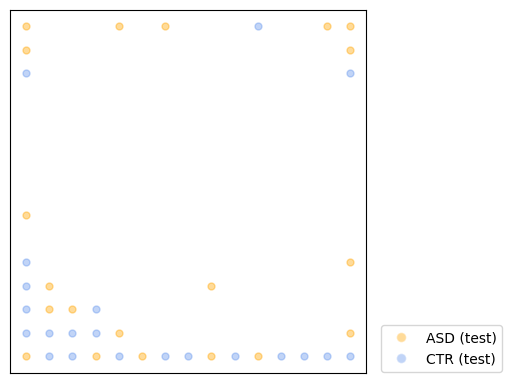

In [9]:
n_test_sq = np.sqrt(n_test).astype(np.int64)
cost = cdist(grid, z_test, 'sqeuclidean')
min_cost, row_assigns, col_assigns = lap.lapjv(np.copy(cost), extend_cost=True)
grid_jv_test = grid[col_assigns]
np.save(os.path.join(res_path, 'grid_jv_test.npy'), grid_jv_test)

grid_jv_int_test = grid_jv_test * (n_train_sq-1)

plt.figure(figsize=(5.5,4))
y_test_2d = np.zeros( (n_train_sq, n_train_sq) )

for i in range(n_test):
  if (y_test[i,0] == 1):
    plt.scatter(grid_jv_test[i,0], grid_jv_test[i,1], marker='o', alpha=0.4, c='orange', s=25)
    y_test_2d[ n_train_sq-1 - np.round(grid_jv_int_test[i,1]).astype(int), np.round(grid_jv_int_test[i,0]).astype(int) ] = 1
  else:
    plt.scatter(grid_jv_test[i,0], grid_jv_test[i,1], marker='o', alpha=0.4, c='cornflowerblue', s=25)
    y_test_2d[ n_train_sq-1 - np.round(grid_jv_int_test[i,1]).astype(int), np.round(grid_jv_int_test[i,0]).astype(int) ] = 2

np.save(os.path.join(res_path, 'y_test_2d.npy'), y_test_2d)

legend_elements = [Line2D([0], [0], marker='o', alpha=0.4, color='w', label='ASD (test)',
                          markerfacecolor='orange', markersize=7),
                   Line2D([0], [0], marker='o', alpha=0.4, color='w', label='CTR (test)',
                          markerfacecolor='cornflowerblue', markersize=7)]

plt.xticks([], [])
plt.yticks([], [])
plt.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1.4, 0.15))
plt.tight_layout()
plt.savefig(os.path.join(res_path, f'{method}_latent_space_lap_test.png'), dpi=500)

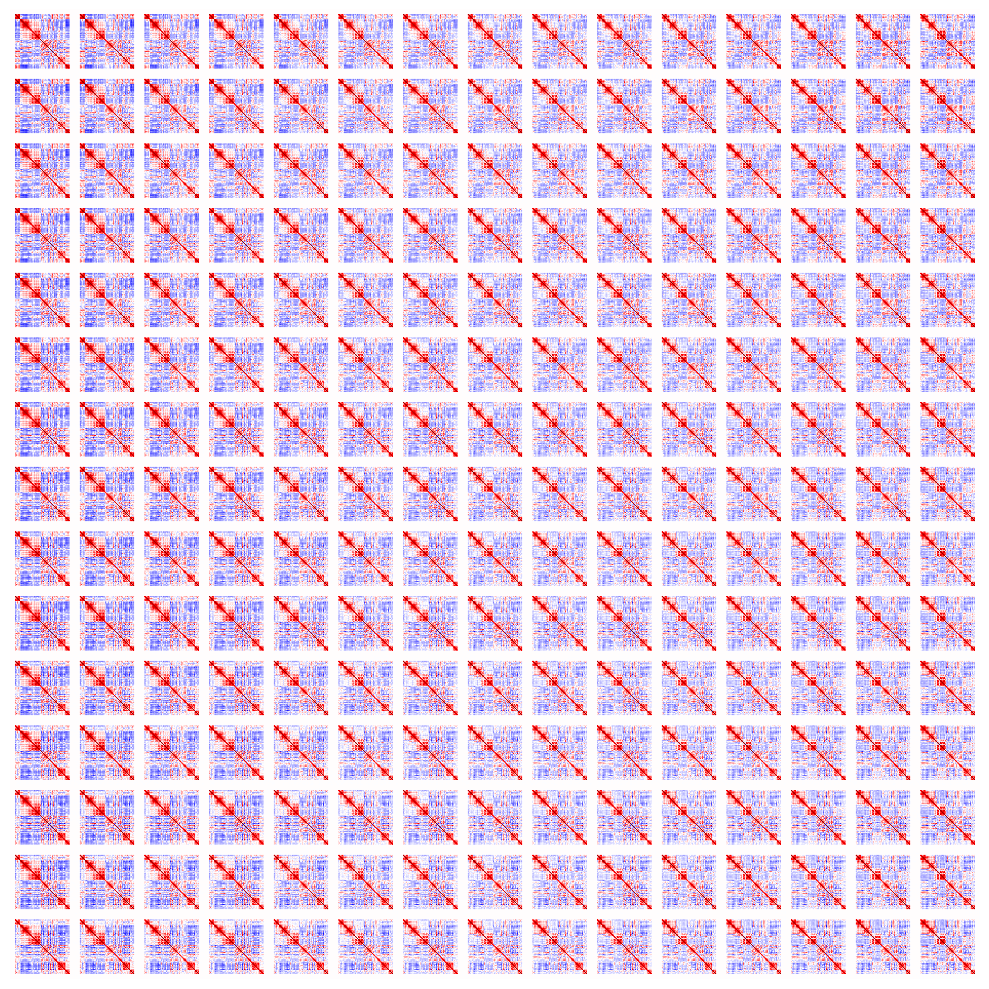

In [ ]:
# display a 2D manifold of generated sFNC
figsize = 10
space = 10
matrix_size = 53

# linearly spaced coordinates in the latent space
scale = np.percentile(np.abs(z_train), 80) # take 80% percentile of the absolute value of z to avoid outliers
grid_x = np.linspace(-scale, scale, n_train_sq)
grid_y = np.linspace(-scale, scale, n_train_sq)[::-1]
fnc_vae = np.zeros(((matrix_size+space) * n_train_sq, (matrix_size+space) * n_train_sq))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.Tensor([[xi, yi]])
        if method in ['vae', 'ivae']:
          x_reconstructed = np.squeeze(model.decode(z_sample).detach().numpy())
        elif method == 'ppca':
          x_reconstructed = model.inverse_transform(z_sample.numpy())
        sfnc = np.zeros((matrix_size, matrix_size))
        sfnc[np.triu_indices(matrix_size, 1)] = x_reconstructed
        sfnc[np.tril_indices(matrix_size, -1)] = sfnc.T[np.tril_indices(53, -1)]
        sfnc[np.diag_indices(matrix_size)] = 1

        fnc_vae[
            i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+53,
            j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+53,
        ] = sfnc

np.save(os.path.join(res_path, f'fnc_{method}.npy'), fnc_vae)

plt.figure(figsize=(figsize, figsize))

colorbar_scale = 1
plt.axis('off')
plt.imshow(fnc_vae, cmap="seismic", vmin=-colorbar_scale, vmax=colorbar_scale)
plt.tight_layout()
plt.savefig(os.path.join(res_path, f'fnc_{method}.png'), dpi=500)

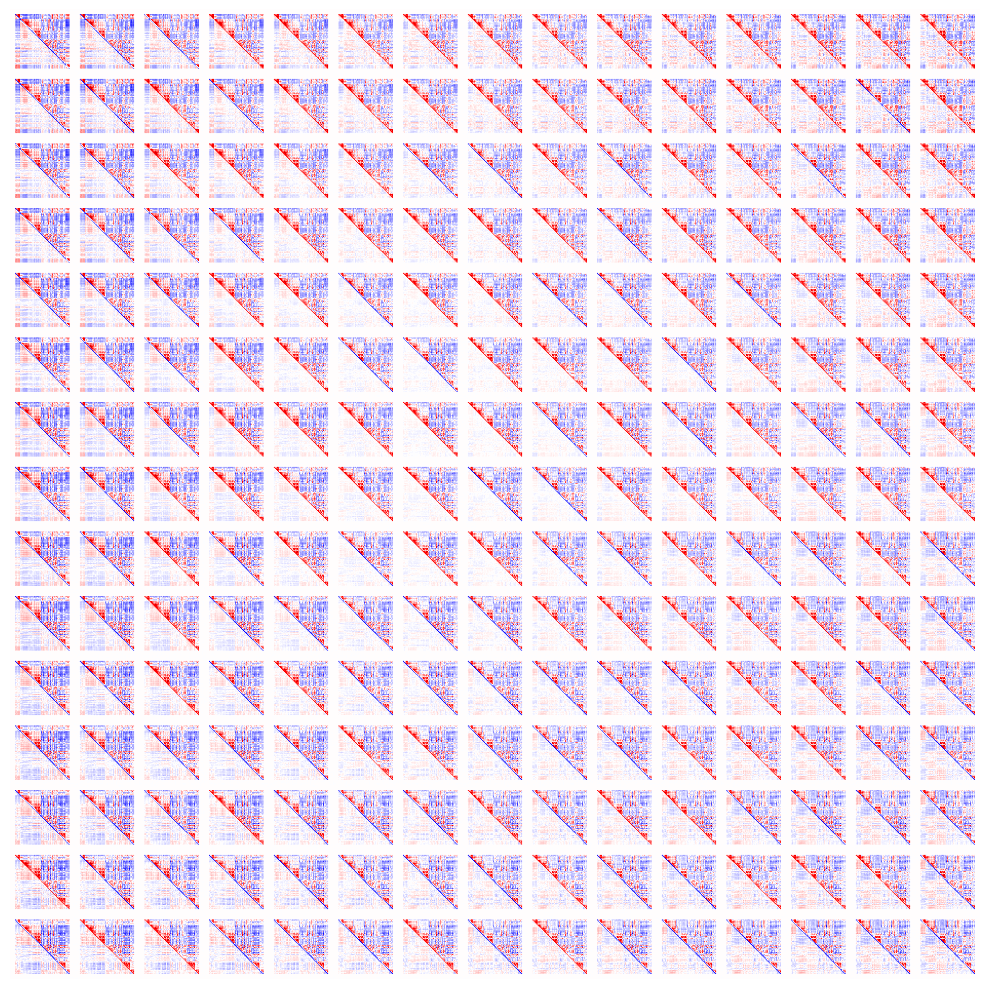

In [ ]:
# display a 2D manifold of generated sFNC with mean removed
fnc_vae_list = []
fnc_vae_mean_removed = copy.copy(fnc_vae)
fnc_vae_mean_rm = np.zeros(fnc_vae_mean_removed.shape)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        fnc_vae_list.append(fnc_vae[
            i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
            j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
        ])

fnc_vae_mean = np.mean(np.array(fnc_vae_list), axis=0)
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        sfnc = copy.copy(fnc_vae_mean_removed[
            i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
            j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
        ])
        sfnc[np.tril_indices(matrix_size, -1)] = sfnc[np.tril_indices(matrix_size, -1)] - fnc_vae_mean[np.tril_indices(matrix_size, -1)]
        if y_train_2d[i, j] == 1:
          sfnc[ np.diag_indices(53) ] = 0.5
        else:
          sfnc[ np.diag_indices(53) ] = -0.5

        fnc_vae_mean_rm[
            i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
            j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
        ] = sfnc
np.save(os.path.join(res_path, f'fnc_{method}_mean_rm.npy'), fnc_vae_mean_rm)

plt.figure(figsize=(figsize, figsize))

colorbar_scale = 1
plt.axis('off')
plt.imshow(fnc_vae_mean_rm, cmap="seismic", vmin=-colorbar_scale, vmax=colorbar_scale)
plt.tight_layout()
plt.savefig(os.path.join(res_path, f'fnc_{method}_diag_mean_removed.png'), dpi=500)

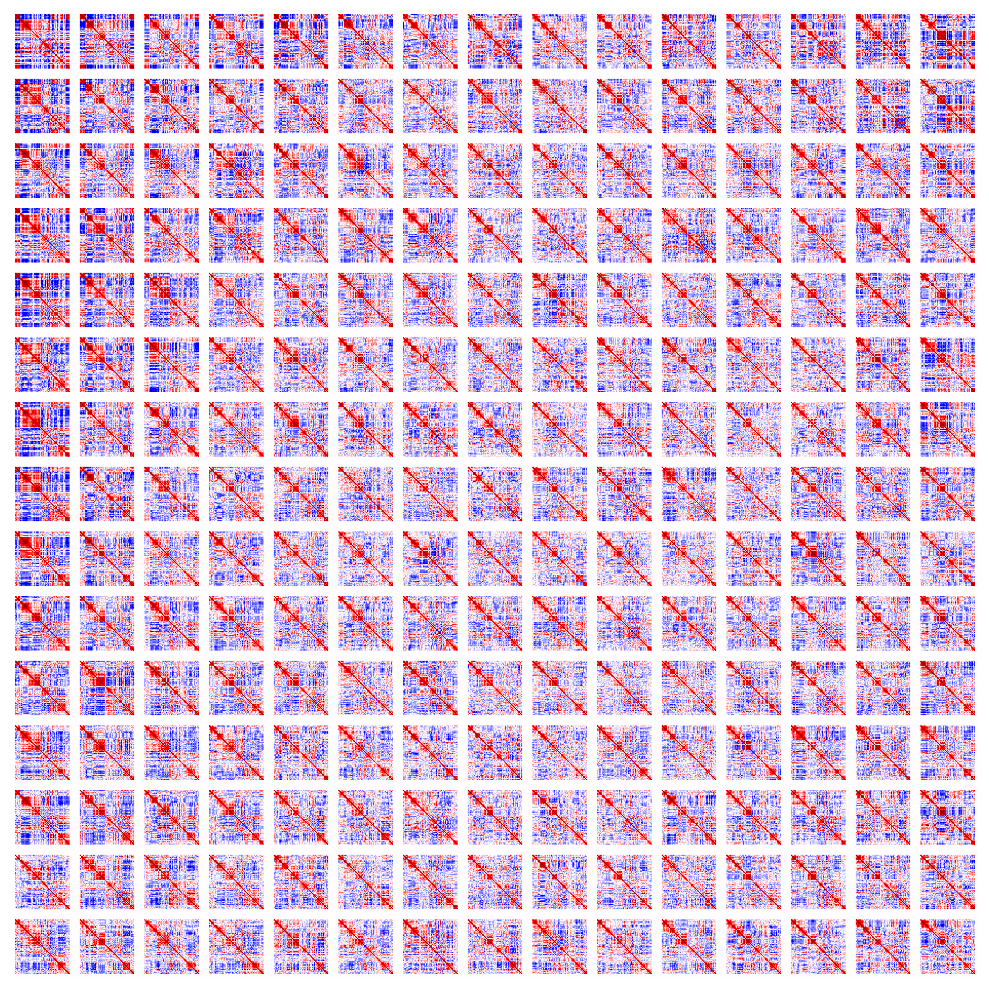

In [ ]:
# display a 2D manifold of original sFNC
fnc_orig = np.zeros(( (matrix_size+space) * n_train_sq, (matrix_size+space) * n_train_sq))
for sub in range(grid_jv_int.shape[0]):
    i = (n_train_sq-1) - round(grid_jv_int[sub, 1])
    j = round(grid_jv_int[sub, 0])
    fnc_orig[
        i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
        j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
    ] = sfnc_data_raw_train[sub]
np.save(os.path.join(res_path, 'fnc_orig.npy'), fnc_orig)

plt.figure(figsize=(figsize, figsize))

colorbar_scale = 1
plt.axis('off')
plt.imshow(fnc_orig, cmap="seismic", vmin=-colorbar_scale, vmax=colorbar_scale)
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig.png'), dpi=500)

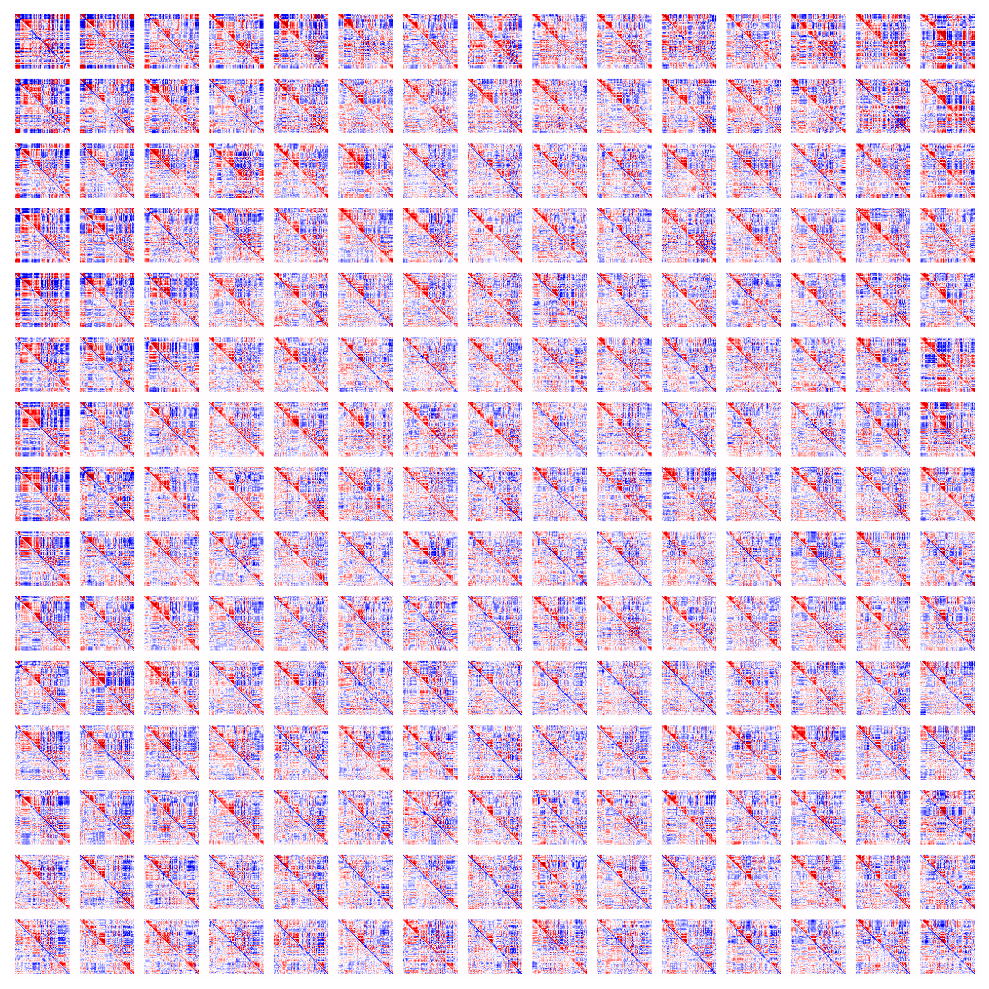

In [ ]:
# display a 2D manifold of original sFNC with mean removed
fnc_orig_mean_rm = np.zeros(( (matrix_size+space) * n_train_sq, (matrix_size+space) * n_train_sq))
for sub in range(grid_jv_int.shape[0]):
  sfnc = copy.copy(sfnc_data_raw_train[sub])
  sfnc_mean_removed = copy.copy(sfnc_data_mean_removed_train[sub])
  if (y_train[sub,0] == 1):
    sfnc[ np.diag_indices(matrix_size) ] = 0.5 # change diagonal value for controls to -1
  else:
    sfnc[ np.diag_indices(matrix_size) ] = -0.5
  sfnc[np.tril_indices(matrix_size, -1)] = sfnc_mean_removed[np.tril_indices(matrix_size, -1)]
  i = (n_train_sq-1) - round(grid_jv_int[sub, 1])
  j = round(grid_jv_int[sub, 0])
  fnc_orig_mean_rm[
      i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
      j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
  ] = sfnc
np.save(os.path.join(res_path, 'fnc_orig_mean_rm.npy'), fnc_orig_mean_rm)

plt.figure(figsize=(figsize, figsize))

colorbar_scale = 1
plt.axis('off')
plt.imshow(fnc_orig_mean_rm, cmap="seismic", vmin=-colorbar_scale, vmax=colorbar_scale)
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig_diag_mean_removed.png'), dpi=500)

In [14]:
fnc_vae_hc_list = []
fnc_vae_pt_list = []
fnc_vae_mean_rm_hc_list = []
fnc_vae_mean_rm_pt_list = []
fnc_vae_hc_test_list = []
fnc_vae_pt_test_list = []
fnc_vae_mean_rm_hc_test_list = []
fnc_vae_mean_rm_pt_test_list = []

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    sfnc = copy.copy(fnc_vae[
        i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
        j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
    ])

    sfnc_mean_rm = copy.copy(fnc_vae_mean_rm[
        i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
        j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
    ])

    if y_train_2d[i, j] == 1:
      fnc_vae_pt_list.append(sfnc)
      fnc_vae_mean_rm_pt_list.append(sfnc_mean_rm)
    elif y_train_2d[i, j] == 2:
      fnc_vae_hc_list.append(sfnc)
      fnc_vae_mean_rm_hc_list.append(sfnc_mean_rm)

    if y_test_2d[i, j] == 1:
      fnc_vae_pt_test_list.append(sfnc)
      fnc_vae_mean_rm_pt_test_list.append(sfnc_mean_rm)
    elif y_test_2d[i, j] == 2:
      fnc_vae_hc_test_list.append(sfnc)
      fnc_vae_mean_rm_hc_test_list.append(sfnc_mean_rm)

In [15]:
network_ind = [4.5, 6.5, 15.5, 24.5, 41.5, 48.5]
network_ind_ = [-0.5, 4.5, 6.5, 15.5, 24.5, 41.5, 48.5, 52.5]
network_label_ind = [(network_ind_[i+1]+network_ind_[i])/2 for i in range(len(network_ind_)-1)]
network_list = ['SC', 'AU', 'SM', 'VI', 'CC', 'DM', 'CB']

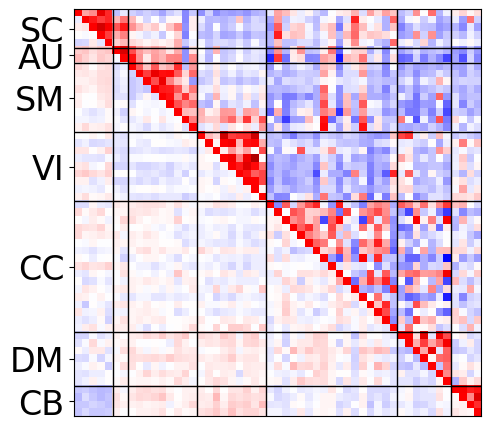

In [16]:
# ASD group average of original sFNC in the training set
abide1_sfnc_data_mean_removed_pt = np.mean(sfnc_data_mean_removed_train[:len(ind_pt_train), :],axis=0) * 2
abide1_sfnc_data_pt = np.mean(sfnc_data_raw_train[:len(ind_pt_train), :],axis=0)
abide1_sfnc_data_pt[np.tril_indices(53, -1)] = abide1_sfnc_data_mean_removed_pt[np.tril_indices(53, -1)]
abide1_sfnc_data_pt[ np.diag_indices(53) ] = 0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_pt, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig_pt_avg_train_final.png'), dpi=600)

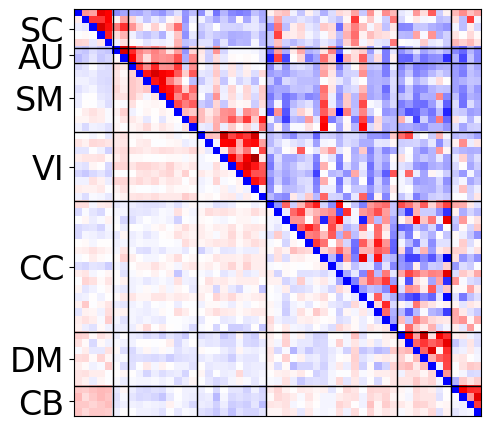

In [17]:
# CTR group average of original sFNC in the training set
abide1_sfnc_data_mean_removed_hc = np.mean(sfnc_data_mean_removed_train[len(ind_pt_train):, :],axis=0) * 2
abide1_sfnc_data_hc = np.mean(sfnc_data_raw_train[len(ind_pt_train):, :],axis=0)
abide1_sfnc_data_hc[np.tril_indices(53, -1)] = abide1_sfnc_data_mean_removed_hc[np.tril_indices(53, -1)]
abide1_sfnc_data_hc[ np.diag_indices(53) ] = -0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_hc, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig_hc_avg_train_final.png'), dpi=600)

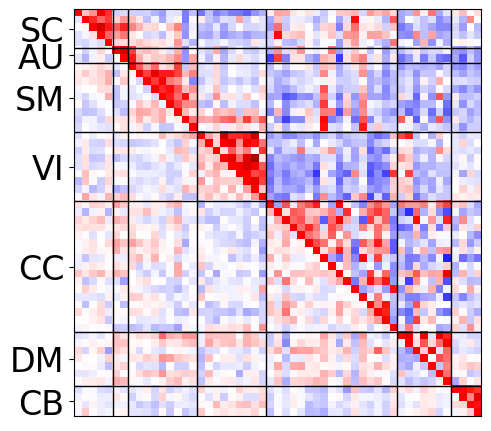

In [18]:
# ASD group average of original sFNC in the test set
abide1_sfnc_data_mean_removed_pt = np.mean(sfnc_data_mean_removed_test[:len(ind_pt_test), :],axis=0) * 2
abide1_sfnc_data_pt = np.mean(sfnc_data_raw_test[:len(ind_pt_test), :],axis=0)
abide1_sfnc_data_pt[np.tril_indices(53, -1)] = abide1_sfnc_data_mean_removed_pt[np.tril_indices(53, -1)]
abide1_sfnc_data_pt[ np.diag_indices(53) ] = 0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_pt, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig_pt_avg_test_final.png'), dpi=600)

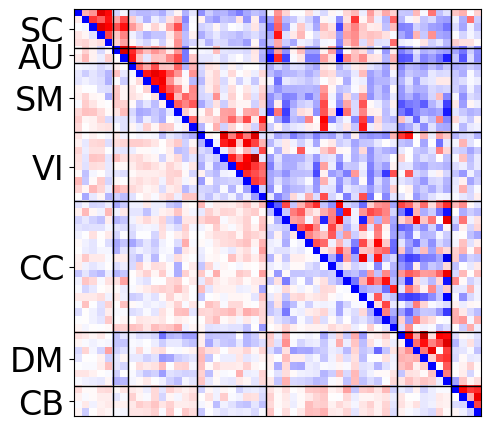

In [19]:
# CTR group average of original sFNC in the test set
abide1_sfnc_data_mean_removed_hc = np.mean(sfnc_data_mean_removed_test[len(ind_pt_test):, :],axis=0) * 2
abide1_sfnc_data_hc = np.mean(sfnc_data_raw_test[len(ind_pt_test):, :],axis=0)
abide1_sfnc_data_hc[np.tril_indices(53, -1)] = abide1_sfnc_data_mean_removed_hc[np.tril_indices(53, -1)]
abide1_sfnc_data_hc[ np.diag_indices(53) ] = -0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_hc, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig_hc_avg_test_final.png'), dpi=600)

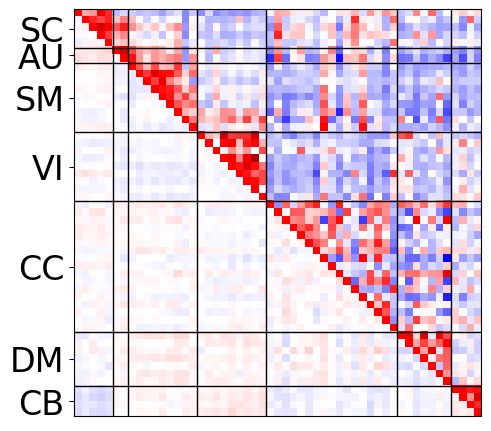

In [20]:
# ASD group average of generated sFNC in the training set
abide1_sfnc_data_pt_mean_rm = np.mean(np.array(fnc_vae_mean_rm_pt_list),axis=0) * 2
abide1_sfnc_data_pt = np.mean(np.array(fnc_vae_pt_list),axis=0)
abide1_sfnc_data_pt[np.tril_indices(53, -1)] = abide1_sfnc_data_pt_mean_rm[np.tril_indices(53, -1)]
abide1_sfnc_data_pt[ np.diag_indices(53) ] = 0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_pt, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'fnc_{method}_pt_avg_train_final.png'), dpi=600)

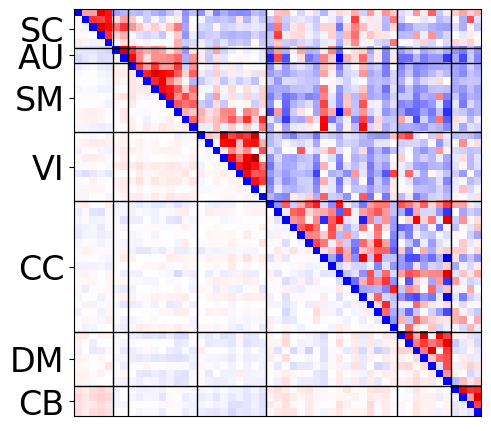

In [21]:
# CTR group average of generated sFNC in the training set
abide1_sfnc_data_hc_mean_rm = np.mean(np.array(fnc_vae_mean_rm_hc_list),axis=0) * 2
abide1_sfnc_data_hc = np.mean(np.array(fnc_vae_hc_list),axis=0)
abide1_sfnc_data_hc[np.tril_indices(53, -1)] = abide1_sfnc_data_hc_mean_rm[np.tril_indices(53, -1)]
abide1_sfnc_data_hc[ np.diag_indices(53) ] = -0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_hc, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'fnc_{method}_hc_avg_train_final.png'), dpi=600)

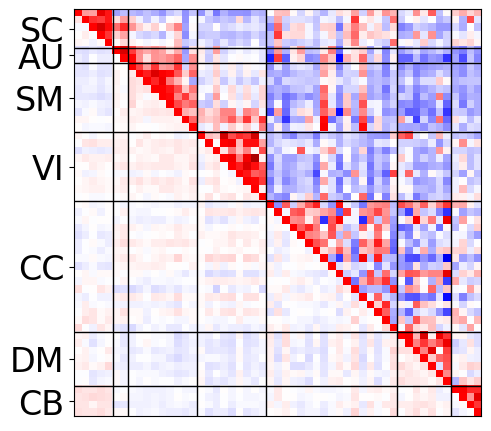

In [22]:
# ASD group average of generated sFNC in the test set
abide1_sfnc_data_pt_mean_rm = np.mean(np.array(fnc_vae_mean_rm_pt_test_list),axis=0) * 2
abide1_sfnc_data_pt = np.mean(np.array(fnc_vae_pt_test_list),axis=0)
abide1_sfnc_data_pt[np.tril_indices(53, -1)] = abide1_sfnc_data_pt_mean_rm[np.tril_indices(53, -1)]
abide1_sfnc_data_pt[ np.diag_indices(53) ] = 0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_pt, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'fnc_{method}_pt_avg_test_final.png'), dpi=600)

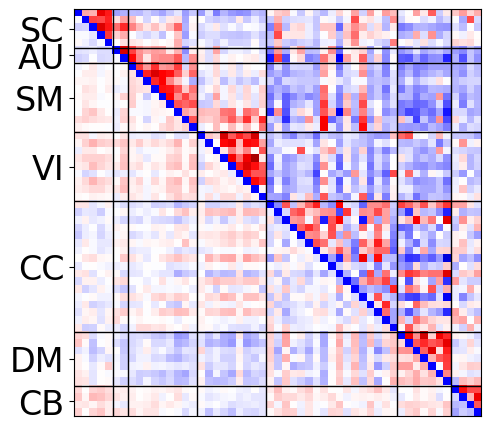

In [23]:
# CTR group average of generated sFNC in the test set
abide1_sfnc_data_hc_mean_rm = np.mean(np.array(fnc_vae_mean_rm_hc_test_list),axis=0) * 2
abide1_sfnc_data_hc = np.mean(np.array(fnc_vae_hc_test_list),axis=0)
abide1_sfnc_data_hc[np.tril_indices(53, -1)] = abide1_sfnc_data_hc_mean_rm[np.tril_indices(53, -1)]
abide1_sfnc_data_hc[ np.diag_indices(53) ] = -0.5

plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks(network_label_ind, network_list, fontsize=24)
plt.imshow(abide1_sfnc_data_hc, cmap="seismic", vmin=-1, vmax=1)
for j in network_ind:
  plt.axhline(y=j, linewidth=1, color='k')
  plt.axvline(x=j, linewidth=1, color='k')

plt.tight_layout()
plt.savefig(os.path.join(res_path, f'fnc_{method}_hc_avg_test_final.png'), dpi=600)

224 54 0.7657047347008067 0.0501669908684227 0.7693932715976463 [0.73920687 0.76939327 0.79926612] 0.8827799150284132 0.5964905022290066


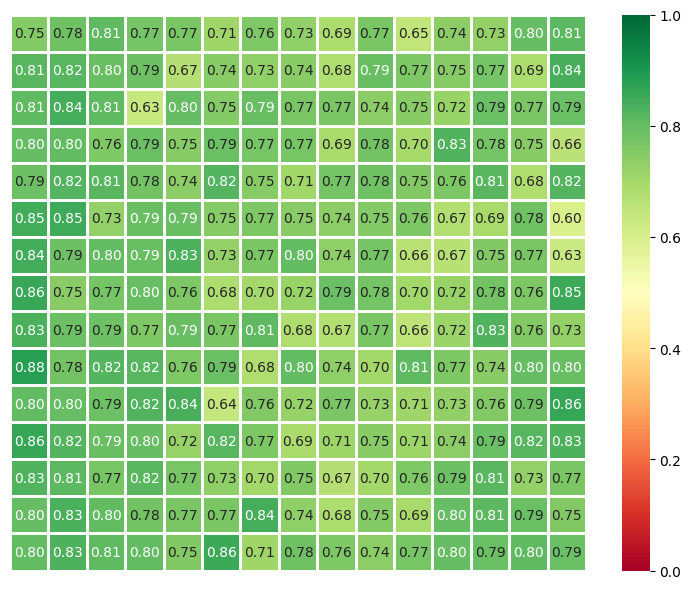

In [24]:
# calculate correlations between original FNC and generated FNC in the training set
orig = np.zeros((n_train_sq, n_train_sq, 1378))
vae = np.zeros((n_train_sq, n_train_sq, 1378))
corr = np.zeros((n_train_sq, n_train_sq))
p = np.zeros((n_train_sq, n_train_sq))

for i in range(n_train_sq):
  for j in range(n_train_sq):
    orig[i,j,:] = fnc_orig[i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size, j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size][np.triu_indices(53, 1)]
    vae[i,j,:] = fnc_vae[i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size, j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size][np.triu_indices(53, 1)]
    corr[i,j], p[i,j] = pearsonr(orig[i,j,:], vae[i,j,:])

np.save(os.path.join(res_path, 'corr.npy'), corr)
print(np.sum(corr>0.6), np.sum(corr>0.8), np.mean(corr), np.std(corr), np.median(corr), np.percentile(corr, [25, 50, 75]), np.max(corr), np.min(corr))

plt.figure(figsize=(7.5, 6))
sns.heatmap(np.abs(corr), linewidths=1, annot=True, fmt='.2f', cmap="RdYlGn", vmin=0, vmax=1, cbar_kws={"shrink": 1})
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'corr_fnc.png'), dpi=500)

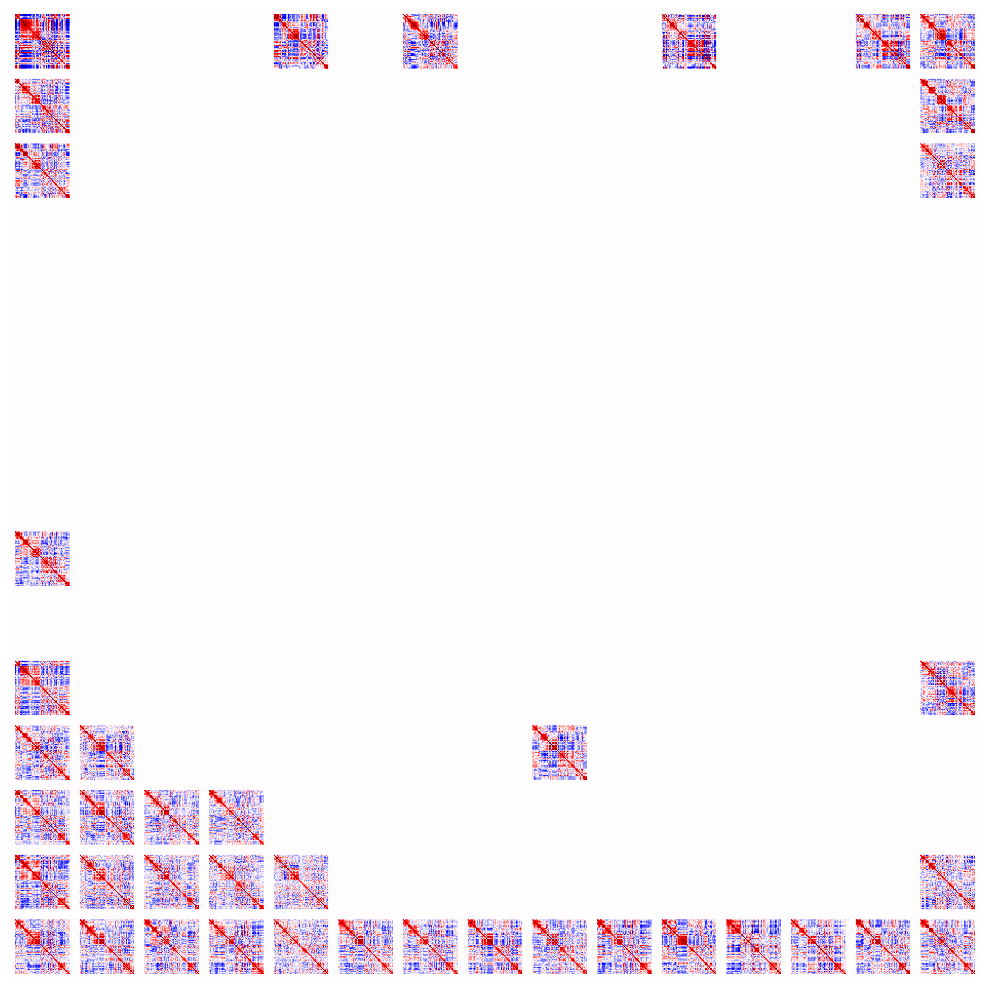

In [ ]:
# display a 2D manifold of original sFNC in the test set
fnc_orig_test = np.zeros(( (matrix_size+space) * n_train_sq, (matrix_size+space) * n_train_sq))
for sub in range(grid_jv_int_test.shape[0]):
    i = (n_train_sq-1) - round(grid_jv_int_test[sub, 1])
    j = round(grid_jv_int_test[sub, 0])
    fnc_orig_test[
        i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+53,
        j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+53,
    ] = sfnc_data_raw_test[sub]
np.save(os.path.join(res_path, 'fnc_orig_test.npy'), fnc_orig_test)

plt.figure(figsize=(figsize, figsize))

colorbar_scale = 1
plt.axis('off')
plt.imshow(fnc_orig_test, cmap="seismic", vmin=-colorbar_scale, vmax=colorbar_scale)
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig_test.png'), dpi=500)

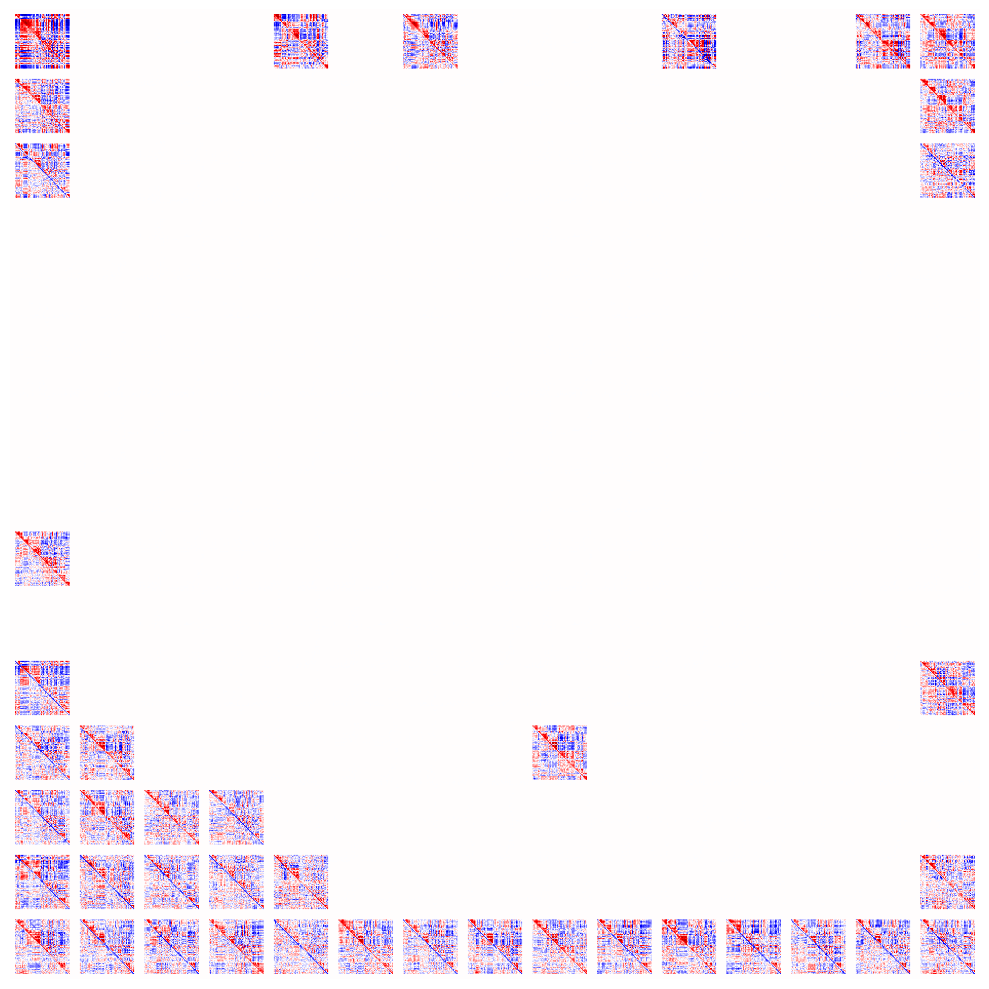

In [ ]:
# display a 2D manifold of original sFNC with mean removed in the test set
fnc_orig_mean_rm_test = np.zeros(( (matrix_size+space) * n_train_sq, (matrix_size+space) * n_train_sq))
for sub in range(grid_jv_int_test.shape[0]):
  sfnc = copy.copy(sfnc_data_raw_test[sub])
  sfnc_mean_removed = copy.copy(sfnc_data_mean_removed_test[sub])
  if (y_test[sub,0] == 1):
    sfnc[np.diag_indices(53)] = 0.5
  else:
    sfnc[np.diag_indices(53)] = -0.5
  sfnc[np.tril_indices(53, -1)] = sfnc_mean_removed[np.tril_indices(53, -1)]
  i = (n_train_sq-1) - round(grid_jv_int_test[sub, 1])
  j = round(grid_jv_int_test[sub, 0])
  fnc_orig_mean_rm_test[
      i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size,
      j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size,
  ] = sfnc
np.save(os.path.join(res_path, 'fnc_orig_mean_rm_test.npy'), fnc_orig_mean_rm_test)

plt.figure(figsize=(figsize, figsize))

colorbar_scale = 1
plt.axis('off')
plt.imshow(fnc_orig_mean_rm_test, cmap="seismic", vmin=-colorbar_scale, vmax=colorbar_scale)
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'fnc_orig_diag_mean_removed_test.png'), dpi=500)

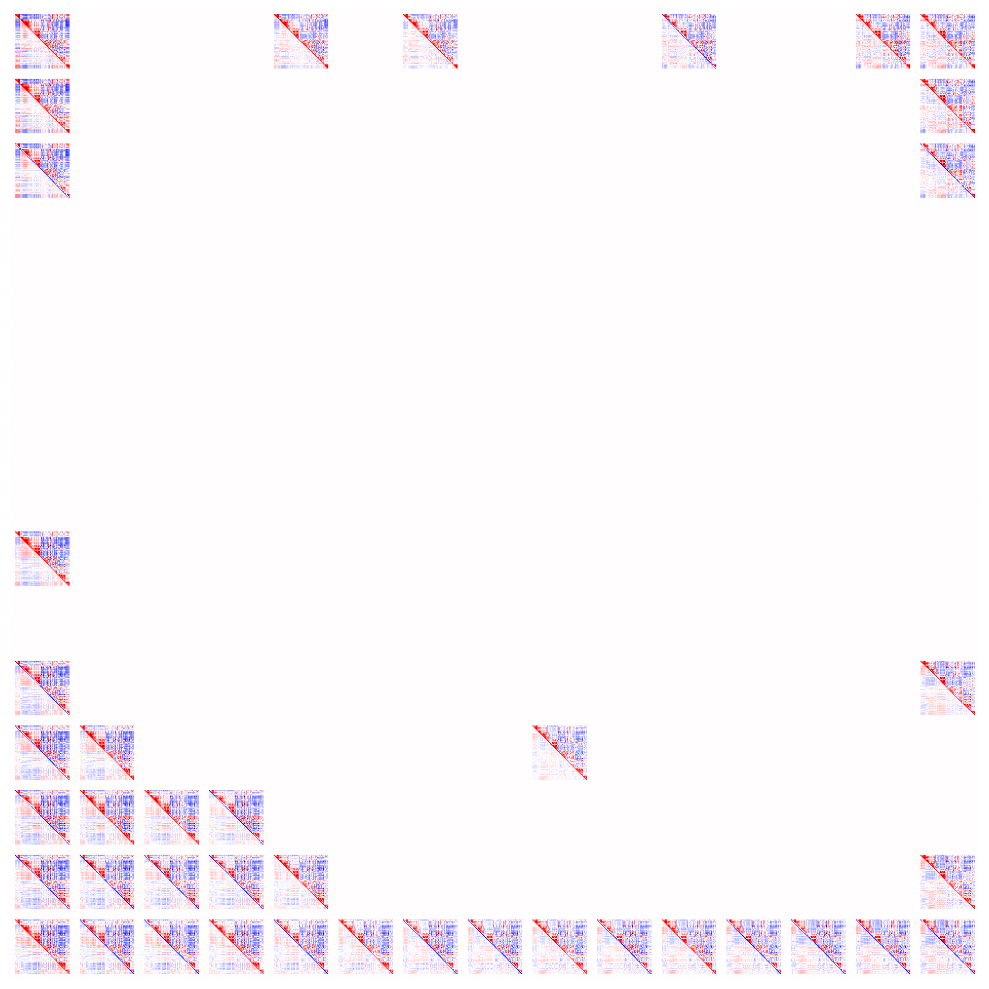

In [ ]:
# display a 2D manifold of generated sFNC with mean removed in the test set
fnc_vae_list = []
fnc_vae_mean_removed = copy.copy(fnc_vae)
fnc_vae_mean_rm = np.zeros(fnc_vae_mean_removed.shape)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        fnc_vae_list.append(fnc_vae[
            i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+53,
            j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+53,
        ])

fnc_vae_mean = np.mean(np.array(fnc_vae_list), axis=0)
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        if y_test_2d[i, j] == 0:
            continue
        sfnc = copy.copy(fnc_vae_mean_removed[
            i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+53,
            j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+53,
        ])
        sfnc[np.tril_indices(53, -1)] = sfnc[np.tril_indices(53, -1)] - fnc_vae_mean[np.tril_indices(53, -1)]
        if y_test_2d[i, j] == 1:
          sfnc[ np.diag_indices(53) ] = 0.5
        else:
          sfnc[ np.diag_indices(53) ] = -0.5

        fnc_vae_mean_rm[
            i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+53,
            j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+53,
        ] = sfnc
np.save(os.path.join(res_path, f'fnc_{method}_mean_rm_test.npy'), fnc_vae_mean_rm)

plt.figure(figsize=(figsize, figsize))

colorbar_scale = 1
plt.axis('off')
plt.imshow(fnc_vae_mean_rm, cmap="seismic", vmin=-colorbar_scale, vmax=colorbar_scale)
plt.tight_layout()
plt.savefig(os.path.join(res_path, f'fnc_{method}_diag_mean_removed_test.png'), dpi=500)

/tmp/ipykernel_2011729/1220160336.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr[i,j], p[i,j] = pearsonr(orig[i,j,:], vae[i,j,:])


39 4 0.7263163426715233 0.0539546018529861 0.7320681545907627 [0.70627809 0.73206815 0.763028  ] 0.8103395732982829 0.5808416360365927


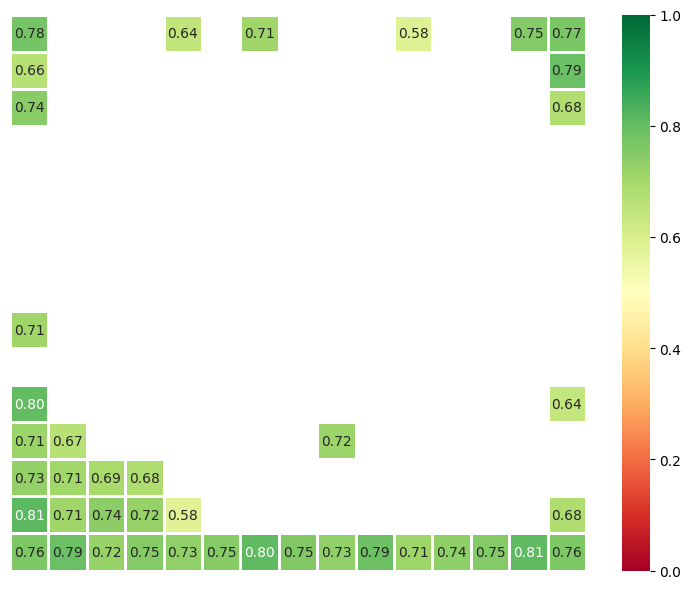

In [28]:
# calculate correlations between original FNC and generated FNC in the test set
orig = np.zeros((n_train_sq, n_train_sq, 1378))
vae = np.zeros((n_train_sq, n_train_sq, 1378))
corr = np.zeros((n_train_sq, n_train_sq))
p = np.zeros((n_train_sq, n_train_sq))

for i in range(n_train_sq):
  for j in range(n_train_sq):
    orig[i,j,:] = fnc_orig_test[i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size, j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size][np.triu_indices(matrix_size, 1)]
    vae[i,j,:] = fnc_vae[i * (matrix_size+space)+space//2 : i * (matrix_size+space)+space//2+matrix_size, j * (matrix_size+space)+space//2 : j * (matrix_size+space)+space//2+matrix_size][np.triu_indices(matrix_size, 1)]
    corr[i,j], p[i,j] = pearsonr(orig[i,j,:], vae[i,j,:])

corr_valid = corr[~np.isnan(corr)]

np.save(os.path.join(res_path, 'corr_test.npy'), corr)
print(np.sum(corr_valid>0.6), np.sum(corr_valid>0.8), np.mean(corr_valid), np.std(corr_valid), np.median(corr_valid), np.percentile(corr_valid, [25, 50, 75]), np.max(corr_valid), np.min(corr_valid))

plt.figure(figsize=(7.5, 6))
sns.heatmap(np.abs(corr), linewidths=1, annot=True, fmt='.2f', cmap="RdYlGn", vmin=0, vmax=1, cbar_kws={"shrink": 1}) #PiYG
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(res_path, 'corr_fnc_test.png'), dpi=500)